In [1]:
from MFEA_lib.tasks.Benchmark.IDPC_EDU import IDPC_EDU_benchmark
from MFEA_lib.model import MFEA_base, SA_MFEA, SMP_MFEA, MFEA1
from MFEA_lib.model.utils import *
from MFEA_lib.operators.Crossover import *
from MFEA_lib.operators.Mutation import *
from MFEA_lib.operators.Selection import *

In [15]:
tasks, IndClass = IDPC_EDU_benchmark.get_tasks(1, num_tasks=10)

Reading data...


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


In [16]:
for t in tasks:
    print(t.name)

idpc_10x10x1000
idpc_10x20x2713
idpc_10x5x425
idpc_15x15x3375
idpc_15x30x12111
idpc_15x7x1504
idpc_20x10x2492
idpc_20x20x8000
idpc_20x40x26104
idpc_25x12x4817


In [17]:
baseModel = MFEA_base.model()
baseModel.compile(
    IndClass= IndClass,
    tasks= tasks,
    # crossover= newSBX(nc = 2, gamma= 0.4, alpha= 6),
    crossover= IDPCEDU_Crossover(),
    mutation= IDPCEDU_Mutation(),
    selection= ElitismSelection()
)
solve = baseModel.fit(
    nb_generations = 500, rmp = 0.3, nb_inds_each_task= 33, 
    bound_pop= [0, 1], evaluate_initial_skillFactor= True
)

Time: 01m 4.68s  100 % [====================>]  Cost: 1.30E+01  1.20E+01  1.30E+01  1.60E+01  1.60E+01  1.80E+01  2.50E+01  2.10E+01  2.10E+01  2.80E+01  ,  
END!


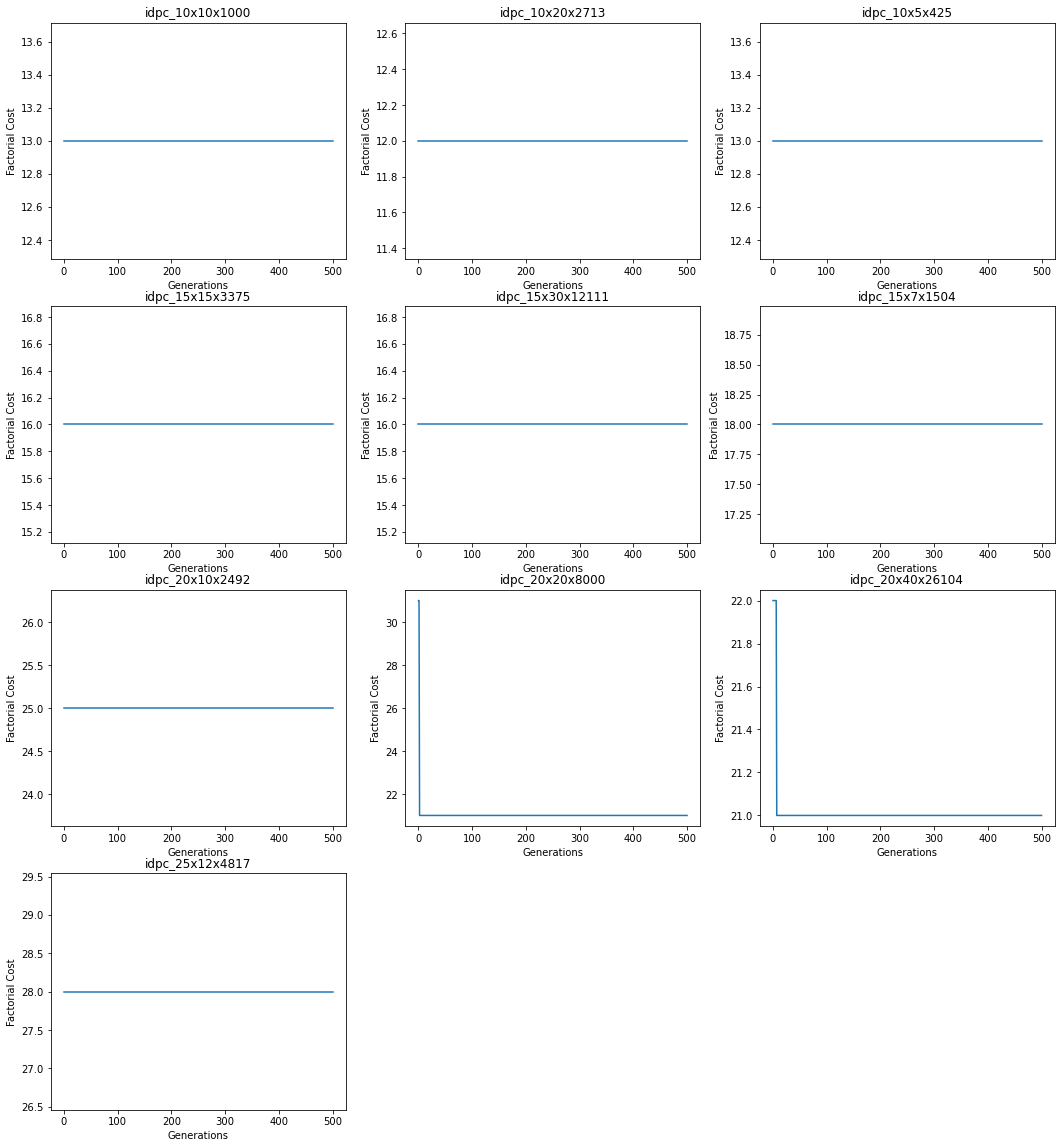

In [18]:
baseModel.render_history()

In [13]:
baseModel = SA_MFEA.model()
baseModel.compile(
    IndClass= IndClass,
    tasks= tasks,
    # crossover= newSBX(nc = 2, gamma= 0.4, alpha= 6),
    crossover= IDPCEDU_Crossover(),
    mutation= IDPCEDU_Mutation(),
    selection= ElitismSelection()
)
solve = baseModel.fit(
    max_inds_each_task= list(np.zeros(shape= (len(tasks),), dtype= int) + 4),
    min_inds_each_task= list(np.zeros(shape= (len(tasks),), dtype= int) + 4),
    max_eval_each_task= list(np.zeros(shape= (len(tasks),), dtype= int) + 500 * 4 ),
    log_oneline= True,
    num_epochs_printed= 1,
    evaluate_initial_skillFactor= True,
    LSA= True
)

'Time: 00m 8.23s '

' 98 % [===================>]  '

'cost: 1.30E+01  1.20E+01  1.30E+01  1.60E+01  1.60E+01  1.80E+01  2.50E+01  2.10E+01  2.20E+01  2.80E+01  2.60E+01  2.70E+01  3.30E+01  4.10E+01  3.50E+01  4.60E+01  4.10E+01  5.00E+01  4.60E+01  4.20E+01  4.20E+01  4.90E+01  4.60E+01  5.00E+01  ,  '

End


In [10]:
smpModel = SMP_MFEA.model()

smpModel.compile(
    IndClass= IndClass,
    tasks= tasks,
    # tasks = GECCO20_benchmark_50tasks.get_items(ID = id),
    # crossover= SBX_Crossover(nc = 2),
    crossover= newSBX(nc = 2, gamma= 0.4, alpha = 6),
    mutation = GaussMutation(scale = 0.1),
    selection= ElitismSelection(random_percent= 0.),
    search = SHADE(len_mem= 30, p_ontop= 0.1)
)
smpModel.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 30,
    lr = 0.15, p_const_intra= 0., p_mutate= 0.1, prob_search = 0.,
    nb_epochs_stop= 1000, swap_po= False,
    evaluate_initial_skillFactor= True
)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 45